In [1]:
!pip install --upgrade pip
!pip install virny


  Using cached pip-25.0.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-25.0.1-py3-none-any.whl (1.8 MB)



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
C:\Users\zhossai3\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import virny
print(virny.__version__)


0.6.0


In [3]:
#Install using an HTTP link
!pip install git+https://github.com/DataResponsibly/Virny.git@feature/add_datasets_for_benchmark

#Install using an SSH link
!pip install git+ssh://git@github.com/DataResponsibly/Virny.git@feature/add_datasets_for_benchmark

  Cloning https://github.com/DataResponsibly/Virny.git (to revision feature/add_datasets_for_benchmark) to c:\users\zhossai3\appdata\local\temp\pip-req-build-nomt_afz


  ERROR: Error [WinError 2] The system cannot find the file specified while executing command git version

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?


  Cloning ssh://****@github.com/DataResponsibly/Virny.git (to revision feature/add_datasets_for_benchmark) to c:\users\zhossai3\appdata\local\temp\pip-req-build-_ws07tje


  ERROR: Error [WinError 2] The system cannot find the file specified while executing command git version

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?


In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

from virny.datasets import GermanCreditDataset
from virny.utils.model_tuning_utils import tune_ML_models
from virny.preprocessing.basic_preprocessing import preprocess_dataset
from virny.utils.data_viz_utils import create_dataset_stats_bar_chart
from virny.utils.custom_initializers import create_models_config_from_tuned_params_df

from pprint import pprint
from datetime import datetime, timezone
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from EDA_utils import get_correlation_with_target, get_correlation_matrix, get_features_by_target_correlation_threshold

## Load dataset

In [7]:
DATASET_SPLIT_SEED = 100
MODELS_TUNING_SEED = 100
TEST_SET_FRACTION = 0.2
DATASET_NAME = 'German_Credit'

sensitive_attributes_dct = {'sex': 'female', 'age': [i for i in range(19, 26)], 'sex & age': None}
sensitive_attributes = [attr for attr in sensitive_attributes_dct.keys() if '&' not in attr]

In [8]:
data_loader = GermanCreditDataset()
data_loader.full_df.head()

,checking-account,duration,credit-history,purpose,credit-amount,savings-account,employment-since,installment-rate,other-debtors,residence-since,...,other-installment,housing,existing-credits,job,number-people-provide-maintenance-for,telephone,foreign-worker,sex,marital-status,class-label
0,<0 DM,6,1,radio/television,1169,no savings account,>=7 years,4,none,4,...,none,own,2,1,1,yes,yes,male,divorced/separated,1
1,0 <= <200 DM,48,2,radio/television,5951,<100 DM,1<= < 4 years,2,none,2,...,none,own,1,1,1,none,yes,female,divorced/separated,0
2,no account,12,1,education,2096,<100 DM,4<= <7 years,2,none,3,...,none,own,1,2,2,none,yes,male,divorced/separated,1
3,<0 DM,42,2,furniture/equipment,7882,<100 DM,4<= <7 years,2,guarantor,4,...,none,for free,1,1,2,none,yes,male,divorced/separated,1
4,<0 DM,24,3,car (new),4870,<100 DM,1<= < 4 years,3,none,4,...,none,for free,2,1,2,none,yes,male,divorced/separated,0


In [9]:
data_loader.target

'class-label'

In [10]:
data_loader.full_df.shape

(1000, 22)

In [11]:
data_loader.full_df.isnull().sum()

checking-account                         0
duration                                 0
credit-history                           0
purpose                                  0
credit-amount                            0
savings-account                          0
employment-since                         0
installment-rate                         0
other-debtors                            0
residence-since                          0
property                                 0
age                                      0
other-installment                        0
housing                                  0
existing-credits                         0
job                                      0
number-people-provide-maintenance-for    0
telephone                                0
foreign-worker                           0
sex                                      0
marital-status                           0
class-label                              0
dtype: int64

## Check proportions and base rates

In [12]:
create_dataset_stats_bar_chart(data_loader.X_data, data_loader.y_data, sensitive_attributes_dct)

alt.FacetChart(...)

### Data Profiling

In [13]:
for col in data_loader.categorical_columns:
    print(f'{col}: {len(data_loader.full_df[col].unique())}')

checking-account: 4
credit-history: 5
purpose: 10
savings-account: 5
employment-since: 5
other-debtors: 3
property: 4
other-installment: 3
housing: 3
job: 4
telephone: 2
foreign-worker: 2
sex: 2
marital-status: 2


In [14]:
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories='auto', handle_unknown='ignore', sparse_output=False), data_loader.categorical_columns)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)
column_transformer = column_transformer.set_output(transform="pandas")  # Set transformer output to a pandas df

In [15]:
full_processed_df = column_transformer.fit_transform(data_loader.full_df)
list(full_processed_df.columns)

['checking-account_0 <= <200 DM',
 'checking-account_<0 DM',
 'checking-account_>= 200 DM ',
 'checking-account_no account',
 'credit-history_1',
 'credit-history_2',
 'credit-history_3',
 'credit-history_4',
 'credit-history_5',
 'purpose_business',
 'purpose_car (new)',
 'purpose_car (used)',
 'purpose_domestic appliances',
 'purpose_education',
 'purpose_furniture/equipment',
 'purpose_others',
 'purpose_radio/television',
 'purpose_repairs',
 'purpose_retraining',
 'savings-account_100 <= <500 DM',
 'savings-account_500 <= < 1000 DM',
 'savings-account_<100 DM',
 'savings-account_>= 1000 DM',
 'savings-account_no savings account',
 'employment-since_1<= < 4 years',
 'employment-since_4<= <7 years',
 'employment-since_<1 years',
 'employment-since_>=7 years',
 'employment-since_unemployed',
 'other-debtors_co-applicant',
 'other-debtors_guarantor',
 'other-debtors_none',
 'property_1',
 'property_2',
 'property_3',
 'property_4',
 'other-installment_bank',
 'other-installment_none',

In [16]:
full_processed_df.head()

,checking-account_0 <= <200 DM,checking-account_<0 DM,checking-account_>= 200 DM,checking-account_no account,credit-history_1,credit-history_2,credit-history_3,credit-history_4,credit-history_5,purpose_business,...,marital-status_divorced/separated,marital-status_married/widowed,duration,credit-amount,installment-rate,residence-since,age,existing-credits,number-people-provide-maintenance-for,class-label
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,6,1169,4,4,67,2,1,1
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,48,5951,2,2,22,1,1,0
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,12,2096,2,3,49,1,2,1
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,42,7882,2,4,45,1,2,1
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,24,4870,3,4,53,2,2,0


### Correlation of sensitive attributes with the target

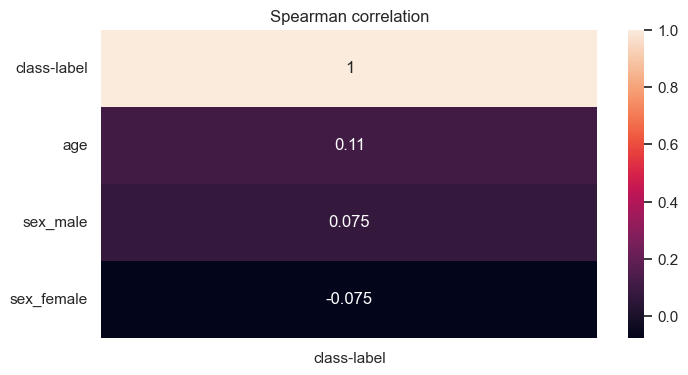

In [17]:
get_correlation_with_target(df=full_processed_df,
                            target_name=data_loader.target,
                            feature_names=[col for col in full_processed_df.columns \
                                           if col != data_loader.target \
                                           and (col.startswith(sensitive_attributes[0]) or col.startswith(sensitive_attributes[1]))
                                           ],
                            heatmap_size=(4, 8))

### Correlation of selected attributes with the target

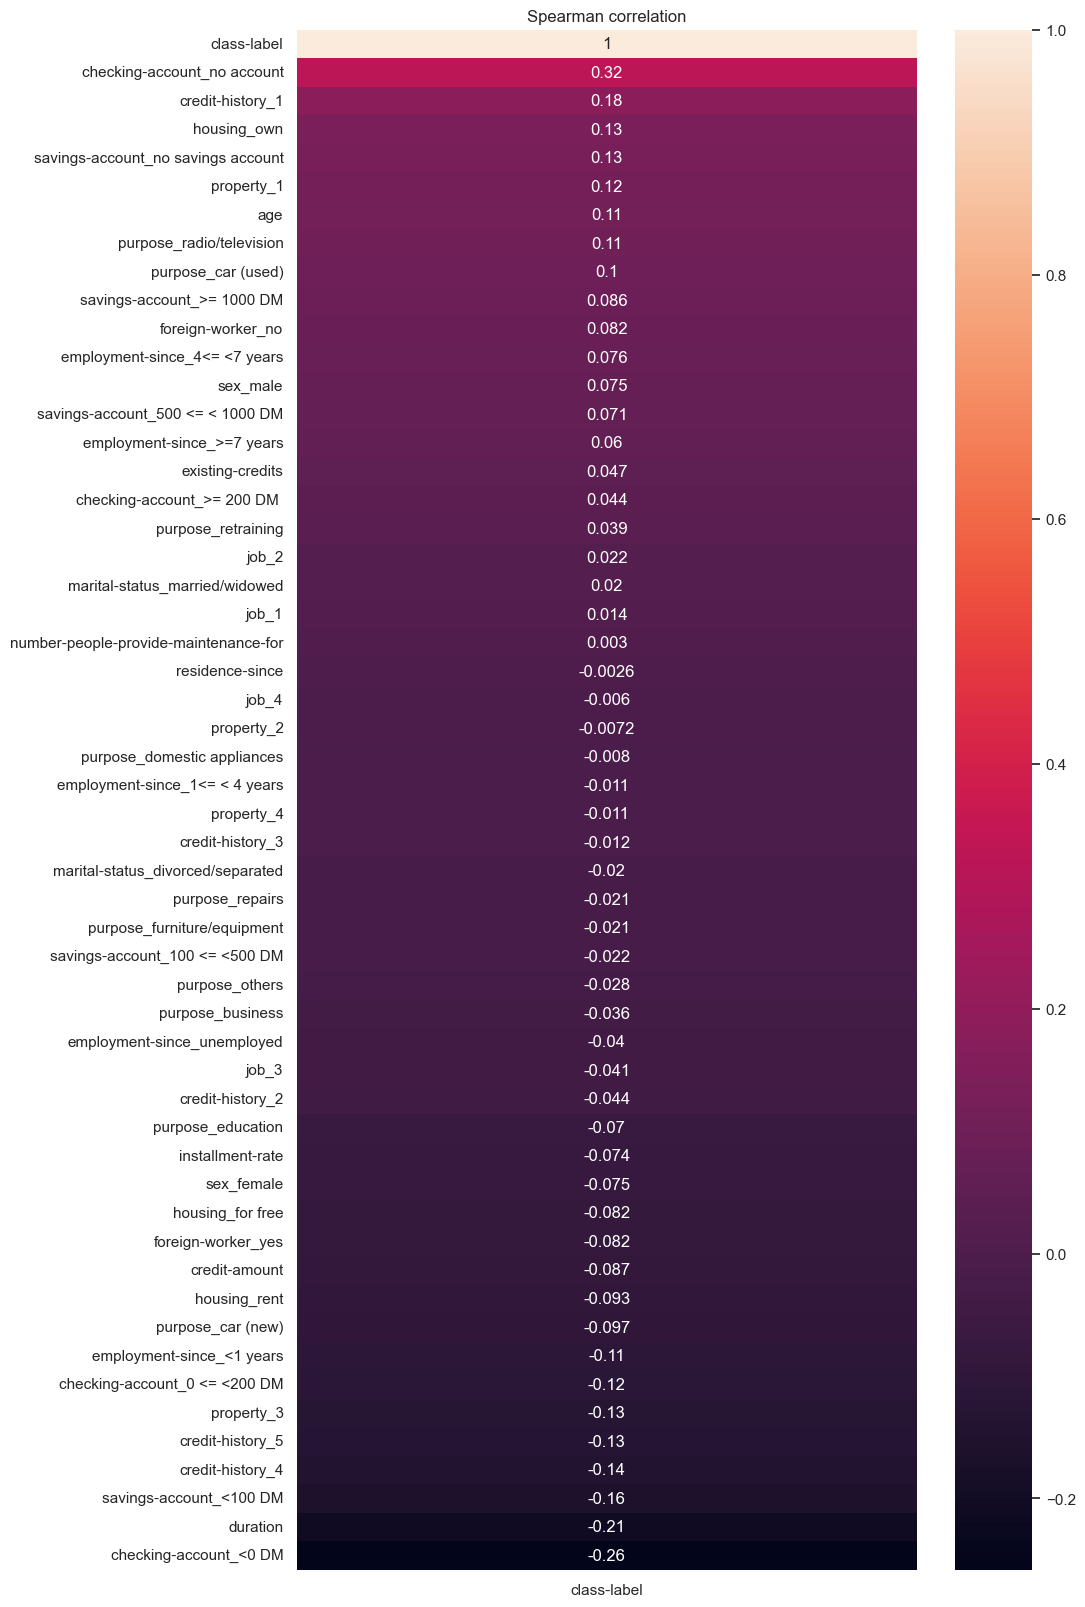

In [18]:
filtered_feature_names = [col for col in full_processed_df.columns 
                          if col != data_loader.target
                            and not col.startswith('other-installment')
                            and not col.startswith('other-debtors')
                            and not col.startswith('telephone')]
get_correlation_with_target(df=full_processed_df,
                            target_name=data_loader.target,
                            feature_names=filtered_feature_names,
                            heatmap_size=(20, 10))

### Correlation matrix for features which have high correlation with the target

In [19]:
high_correlated_features = get_features_by_target_correlation_threshold(
    df=full_processed_df[filtered_feature_names + [data_loader.target]],
    target=data_loader.target,
    threshold=0.12
)
high_correlated_features

['checking-account_<0 DM',
 'checking-account_no account',
 'credit-history_1',
 'credit-history_4',
 'credit-history_5',
 'savings-account_<100 DM',
 'savings-account_no savings account',
 'property_3',
 'housing_own',
 'duration']

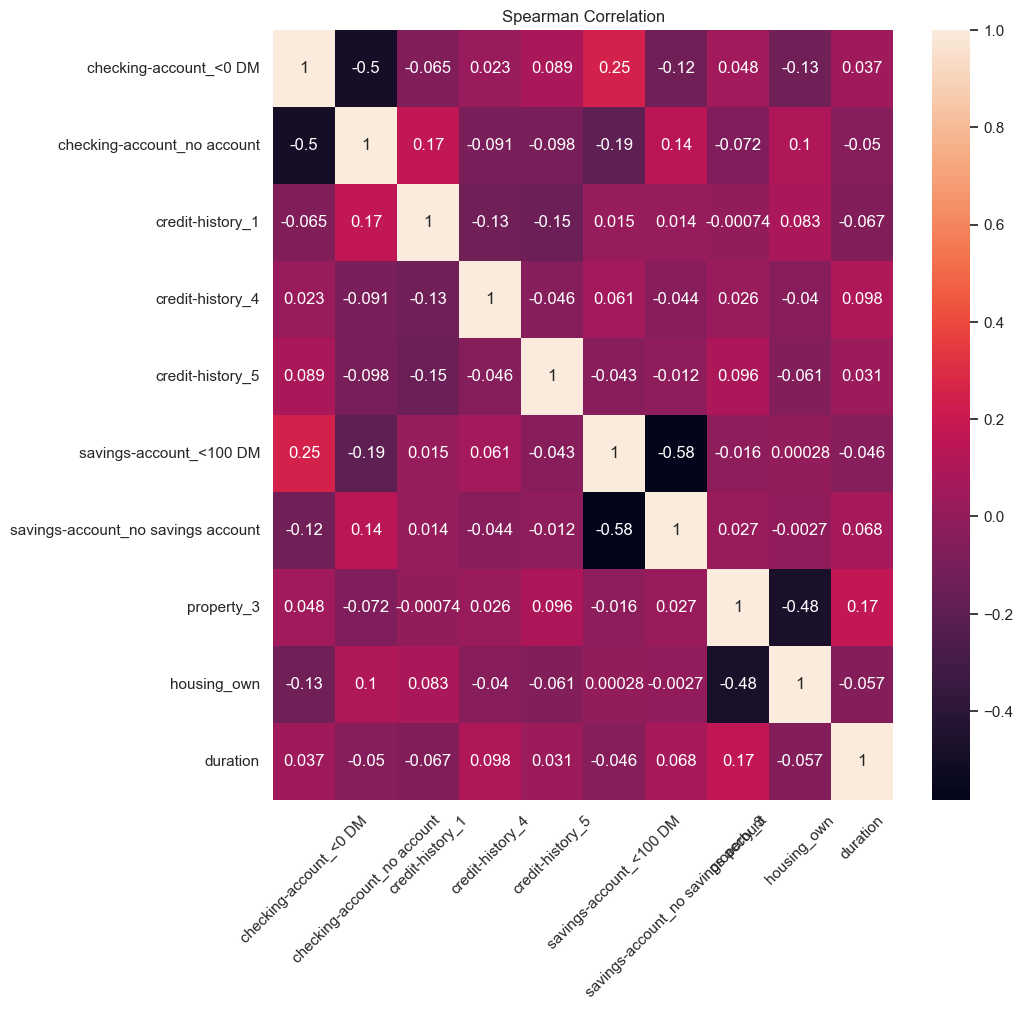

In [20]:
get_correlation_matrix(df=full_processed_df,
                       feature_names=high_correlated_features,
                       heatmap_size=(10, 10))

## Data preparation

In [22]:
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories='auto', handle_unknown='ignore', sparse_output=False), data_loader.categorical_columns),
        ('num', StandardScaler(), data_loader.numerical_columns),
    ],
    verbose_feature_names_out=False
)

In [23]:
base_flow_dataset = preprocess_dataset(data_loader=data_loader,
                                       column_transformer=column_transformer,
                                       sensitive_attributes_dct=sensitive_attributes_dct,
                                       test_set_fraction=TEST_SET_FRACTION,
                                       dataset_split_seed=DATASET_SPLIT_SEED)

## Tune RandomForest

In [24]:
models_params_for_tuning = {
    'RandomForestClassifier': {
        'model': RandomForestClassifier(random_state=MODELS_TUNING_SEED),
        'params': {
            'n_estimators': [100, 200, 500],
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }
    },
}

In [27]:
tuned_params_df, models_config = tune_ML_models(models_params_for_tuning, base_flow_dataset, DATASET_NAME, n_folds=3)
tuned_params_df

2025/02/17, 23:51:00: Tuning RandomForestClassifier...
2025/02/17, 23:58:38: Tuning for RandomForestClassifier is finished [F1 score = 0.6738369281327793, Accuracy = 0.7512789464297448]



,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,German_Credit,RandomForestClassifier,0.673837,0.751279,"{'bootstrap': False, 'max_depth': 20, 'min_sam..."


In [30]:
now = datetime.now(timezone.utc)
date_time_str = now.strftime("%Y%m%d__%H%M%S")
tuned_df_path = os.path.join(os.getcwd(), 'models_tuning', f'tuning_results_{DATASET_NAME}.csv')
tuned_params_df.to_csv(tuned_df_path, sep=",", columns=tuned_params_df.columns, float_format="%.4f", index=False)

## Analyze Feature Importance With Scikit-Learn

In [31]:
tuned_df_path = os.path.join(os.getcwd(), 'models_tuning', f'tuning_results_{DATASET_NAME}.csv')
models_config = create_models_config_from_tuned_params_df(models_params_for_tuning, tuned_df_path)
pprint(models_config)

{'RandomForestClassifier': RandomForestClassifier(bootstrap=False, max_depth=20, random_state=100)}


In [32]:
rf = models_config['RandomForestClassifier']
rf = rf.fit(base_flow_dataset.X_train_val, base_flow_dataset.y_train_val)

Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

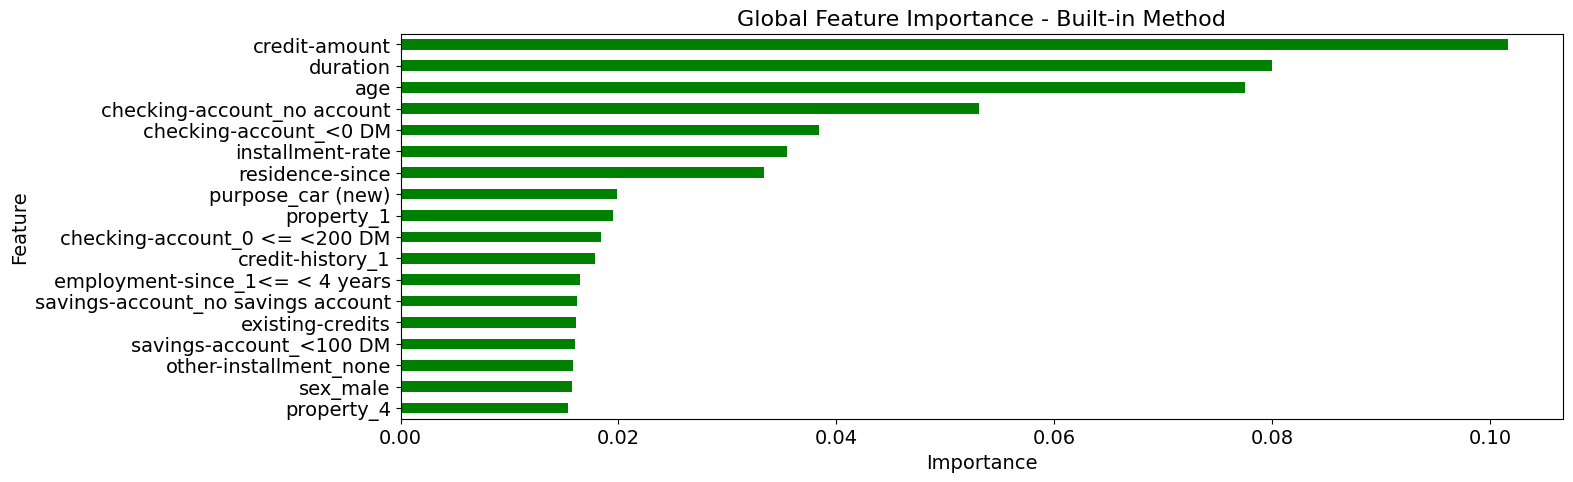

In [33]:
global_importances = pd.Series(rf.feature_importances_, index=base_flow_dataset.X_train_val.columns)
global_importances = global_importances[global_importances > 0.015]
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')

plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Global Feature Importance - Built-in Method", fontsize=16)